In [1]:
#%tensorflow_version 2.x

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [8]:
import sys
projectDir = "/content/drive/MyDrive/data/tweepfake_deepfake_text_detection"
sys.path.insert(0, projectDir)

random_state = 523 # Fixed seed for replicability of randomic operations.
resultsDir = projectDir+"/data/results"

In [2]:
%%writefile setup.sh

export CUDA_HOME=/usr/local/cuda-10.1
git clone https://github.com/NVIDIA/apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

Writing setup.sh


In [3]:
!sh setup.sh

Cloning into 'apex'...
remote: Enumerating objects: 9562, done.
remote: Counting objects: 100% (633/633), done.
remote: Compressing objects: 100% (426/426), done.
remote: Total 9562 (delta 362), reused 383 (delta 191), pack-reused 8929
Receiving objects: 100% (9562/9562), 14.82 MiB | 22.68 MiB/s, done.
Resolving deltas: 100% (6475/6475), done.
/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:232: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3

In [4]:
!pip install pandas transformers simpletransformers==0.41 amp

     |████████████████████████████████| 4.0 MB 7.6 MB/s 
     |████████████████████████████████| 191 kB 63.6 MB/s 
     |████████████████████████████████| 125 kB 59.8 MB/s 
     |████████████████████████████████| 5.6 MB 47.9 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 895 kB 61.5 MB/s 
     |████████████████████████████████| 596 kB 50.2 MB/s 
     |████████████████████████████████| 77 kB 8.6 MB/s 
     |████████████████████████████████| 3.8 MB 49.3 MB/s 
     |████████████████████████████████| 3.5 MB 47.3 MB/s 
     |████████████████████████████████| 3.5 MB 42.4 MB/s 
     |████████████████████████████████| 3.5 MB 42.9 MB/s 
     |████████████████████████████████| 3.4 MB 46.8 MB/s 
     |████████████████████████████████| 3.4 MB 51.6 MB/s 
     |████████████████████████████████| 3.3 MB 50.7 MB/s 
     |████████████████████████████████| 3.1 MB 48.0 MB/s 
     |████████████████████████████████| 3.1 MB 46.6 MB/s 
     |█████████████

In [9]:
# from DataHandler import DataHandler
import pandas as pd

csvTrainDataset = projectDir+"/data/splits/train.csv"
csvValDataset = projectDir+"/data/splits/validation.csv"
csvTestDataset = projectDir+"/data/splits/test.csv"

bertDir = projectDir+"/data/encoded/bert"
# dh = DataHandler()
# dfTrain = dh.readCSVData(csvTrainDataset)
# dfVal = dh.readCSVData(csvValDataset)
# dfTest = dh.readCSVData(csvTestDataset)
dfTrain = pd.read_csv(csvTrainDataset, sep=';')
dfVal = pd.read_csv(csvValDataset, sep=';')
dfTest = pd.read_csv(csvTestDataset, sep=';')

In [10]:
dfTrain

,screen_name,text,account.type,class_type
0,imranyebot,YEA now that note GOOD,bot,others
1,zawvrk,Listen to This Charming Man by The Smiths htt...,human,human
2,zawarbot,wish i can i would be seeing other hoes on the...,bot,others
3,ahadsheriffbot,The decade in the significantly easier schedul...,bot,others
4,kevinhookebot,"""Theim class=\""alignnone size-full wp-image-60...",bot,rnn
...,...,...,...,...
20707,AINarendraModi,Met on the Abversion of our science for the co...,bot,rnn
20708,AINarendraModi,Land for their during the opportunity to the p...,bot,rnn
20709,DeepDrumpf,@TayandYou doesn't have a clue. You're right. ...,bot,rnn
20710,jaden,Me And My Bestie https://t.co/vPq2iDkWZm,human,human


In [11]:
# Select interesting columns for this study.
dfTrainDataset = dfTrain[["screen_name", "text", "account.type"]]
dfValDataset = dfVal[["screen_name", "text", "account.type"]]
dfTestDataset = dfTest[["screen_name", "text", "account.type"]]

In [12]:
dfTrainDataset

,screen_name,text,account.type
0,imranyebot,YEA now that note GOOD,bot
1,zawvrk,Listen to This Charming Man by The Smiths htt...,human
2,zawarbot,wish i can i would be seeing other hoes on the...,bot
3,ahadsheriffbot,The decade in the significantly easier schedul...,bot
4,kevinhookebot,"""Theim class=\""alignnone size-full wp-image-60...",bot
...,...,...,...
20707,AINarendraModi,Met on the Abversion of our science for the co...,bot
20708,AINarendraModi,Land for their during the opportunity to the p...,bot
20709,DeepDrumpf,@TayandYou doesn't have a clue. You're right. ...,bot
20710,jaden,Me And My Bestie https://t.co/vPq2iDkWZm,human


In [13]:
X_train_all = dfTrainDataset.drop(columns=['screen_name'])
X_train_all.columns = ["text", "label"]

X_val_all = dfValDataset.drop(columns=['screen_name'])
X_val_all.columns = ["text", "label"]

X_test_all = dfTestDataset.drop(columns=['screen_name'])
X_test_all.columns = ["text", "label"]

dictLabels = {"human":0, "bot":1}
dictLabelsReverse = {0:"human", 1: "bot"}

X_train_all["label"] = X_train_all["label"].apply(lambda x: dictLabels[x])
X_val_all["label"] = X_val_all["label"].apply(lambda x: dictLabels[x])
X_test_all["label"] = X_test_all["label"].apply(lambda x: dictLabels[x])
y_train = X_train_all["label"]
y_val = X_val_all["label"]
y_test = X_test_all["label"]

In [14]:
train_labels = y_train.tolist()
val_labels = y_val.tolist()
test_labels = y_test.tolist()

In [15]:
from simpletransformers.classification import ClassificationModel

# Create a ClassificationModel
model = ClassificationModel('bert', 'bert-base-cased', args={'fp16': False, 'num_train_epochs': 3, "overwrite_output_dir":True}) # You can set class weights by using the optional weight argument

# Train the model
model.train_model(X_train_all)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:270: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/20712 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0:   0%|          | 0/2589 [00:00<?, ?it/s]

Running loss: 0.796930

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.263126

Running Epoch 1:   0%|          | 0/2589 [00:00<?, ?it/s]

Running loss: 0.014489

Running Epoch 2:   0%|          | 0/2589 [00:00<?, ?it/s]

Running loss: 0.000716

In [16]:
# Evaluate the model
import sklearn
result, model_outputs, wrong_predictions = model.eval_model(X_test_all, acc=sklearn.metrics.accuracy_score, f1=sklearn.metrics.f1_score)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:691: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2558 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f648cd90f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f648cd90f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Running Evaluation:   0%|          | 0/320 [00:00<?, ?it/s]

In [17]:
result

{'acc': 0.8928850664581705,
 'eval_loss': 0.5467603741922176,
 'f1': 0.8928850664581705,
 'fn': 138,
 'fp': 136,
 'mcc': 0.7857712245696401,
 'tn': 1142,
 'tp': 1142}

In [18]:
predictions = model.predict(X_test_all["text"])[0]

  0%|          | 0/2558 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

In [20]:
import pandas as pd
predictionLabels = [dictLabelsReverse[t] for t in predictions]
dfResults = pd.DataFrame(predictionLabels, columns=["prediction"])
dfResults["gold"] = dfTest[["account.type"]]
# file_name = resultsDir+"/bert_finetuning.csv"
# dfResults.to_csv(file_name, sep='\t', encoding='utf-8')

In [21]:
dfTest["label_bert"] = [dictLabelsReverse[t] for t in predictions]

In [22]:
dfResults.head()

,prediction,gold
0,human,human
1,human,human
2,bot,human
3,bot,bot
4,human,human


In [23]:
def plotErrorRatio(X_test_all, prediction_column, min_sample_num=30):
  X_verify = X_test_all[["screen_name", "text", "account.type", prediction_column]]
  X_count_accounts = X_test_all[["screen_name", "account.type"]].groupby("screen_name").count()
  X_verify = X_verify[X_verify["account.type"] != X_verify[prediction_column]]
  X_verify = X_verify.groupby("screen_name").count()["text"].to_frame()
  X_verify["total"] = X_count_accounts["account.type"]
  X_verify.columns = ["errors", "num_samples"]
  X_verify["error_ratio"] = X_verify["errors"] / X_verify["num_samples"]
  X_verify[X_verify["num_samples"] >= min_sample_num]["error_ratio"].plot.bar(figsize=(15,5))
  return X_verify

,errors,num_samples,error_ratio
screen_name,,,
DeepDrumpf,1,29,0.034483
GenePark,1,22,0.045455
GenePark_GPT2,8,22,0.363636
Gpt2Wint,2,2,1.000000
Musk_from_Mars,1,2,0.500000
Thorin,1,10,0.100000
UtilityLimb,2,4,0.500000
VBoterin,2,13,0.153846
ahadsheriff,17,95,0.178947


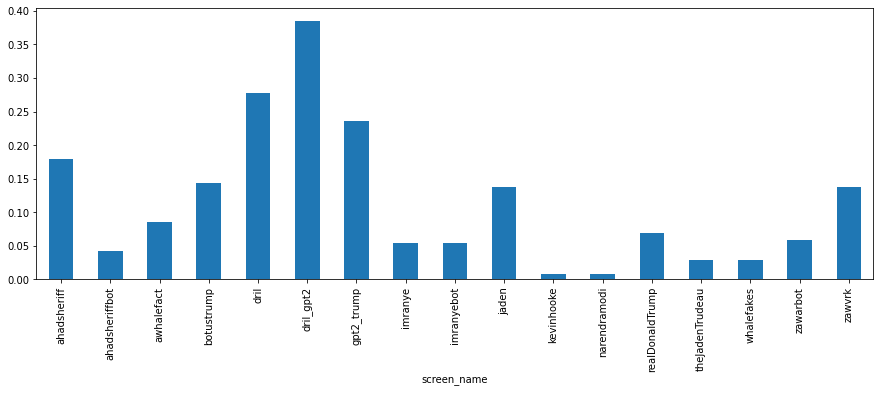

In [24]:
plotErrorRatio(dfTest, "label_bert")